In [1]:
#annulus Average Script

##############################################################################################################
#let's take two radii and compute the average between them
import os
import glob
import subprocess
import matplotlib.pyplot as plt
import pandas as pd
import math
from numpy import *
from pylab import *
#import pygrib

import pyproj
import metpy.calc as mpcalc
import cartopy.crs as ccrs
from cartopy.geodesic import Geodesic
import cartopy.feature as cfeature
import cartopy.crs as crs
from cartopy.feature import NaturalEarthFeature
import wrf
from wrf import (to_np, interplevel, geo_bounds, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import shutil
# Download state and coastline data
states = NaturalEarthFeature(category="cultural", scale="50m",
                          facecolor="none", name="admin_1_states_provinces_shp")
from scipy.interpolate import RegularGridInterpolator
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as ticker
from scipy.ndimage import gaussian_filter

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime

import imageio
import glob

In [2]:
#only run the cell below for the 1.33 kilometer inner nest

#Function Below is for a storm following map projection. Credit: Dr. Sharanya Majumdar @The University of Miami
dataproj = ccrs.PlateCarree()

def create_map_background(tclon,tclat):

    tclon5a=5*(int(tclon/5)-1)
    tclon5b=5*(int(tclon/5))
    tclat5a=5*(int(tclat/5)-1)
    tclat5b=5*(int(tclat/5))
     
    #Specify plot size
    fig=plt.figure(figsize=(15, 15))
    ax=plt.subplot(111, projection=dataproj)
    
    #specify boundary extent from TC center. Current specifications give us a 10° x 10° projection
    ax.set_extent([tclon-4, tclon+4, tclat-4, tclat+4],ccrs.PlateCarree()) #Constrain FOV of plot
    return fig, ax

In [3]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def wind_scale():
    newcmp = LinearSegmentedColormap.from_list("", [
    (0/200, "#000000"),    # Black at 0
    (36/200, "#a6a6a6"),   # Grey at 34
    (36/200, "#4245a6"),   # Dark blue at 34
    (66/200, "#29a668"),   # Green at 64
    (88/200, "#cccc33"),   # Yellow at 96
    (100/200, "#cc3333"),  # Red at 113
    (116/200, "#cc7acc"),  # Pink at 137
    (140/200, "#ffffff"),  # White at 160
    (200/200, "#8B4513")   # Brown at 200
    ])

    return newcmp

In [4]:
#Pressure levels we are considering for our aziumuthal averages
plevs  = [100000., 99000., 98000., 97000., 96000., 95000., 94000., 93000., 92000., 91000.,
           90000., 89000., 88000., 87000., 86000., 85000., 84000., 83000., 82000., 81000., 80000.,
           77500., 75000., 72500., 70000., 67500., 65000., 62500., 60000., 57500., 55000., 52500.,
           50000., 47500., 45000., 42500., 40000., 37500., 35000., 32500., 30000., 27500., 25000.,
           22500., 20000., 17500., 15000., 12500., 10000., 7500., 6000.]

#Vertical levels we are considering for azimuthal averages 
zlevs = [ 10., 20., 30., 40., 50., 60., 70., 80., 90., 100.,  200.,  300.,  400.,  500.,  600.,  700.,  800.,  900., 1000.,
         1100., 1200., 1300., 1400., 1500., 1600., 1700., 1800., 1900., 2000., 2250.,
         2500., 2750., 3000., 3250., 3500., 3750., 4000., 4250., 4500., 4750., 5000.,
         5500., 6000., 6500., 7000., 7500., 8000., 8500., 9000., 9500., 10000., 10500.,
         11000., 11500., 12000., 12500., 13000., 13500., 14000., 14500., 15000., 15500.,
         16000., 16500., 17000., 17500., 18000., 18500.]

nlevs   = len(plevs) #level of interest is 850 hPa, which is the sixth level
n_zlevs = len(zlevs)

print("Number of Pressure levels in the vertical", nlevs)
print("Number of height levels in the vertical", n_zlevs)
yplabs = ['']*nlevs
yzlabs = ['']*n_zlevs

Number of Pressure levels in the vertical 51
Number of height levels in the vertical 68


In [8]:
# set some constants for later use that we may or may not use, just there for any meteorological claculation you may conduct
deltap     = 5000.        # vertical isobaric spacing
resol      = 0.5          # degrees
pref       = 100000.      # Pa
cv         = 717.         # J kg-1 K-1
cp         = 1004.7       # J kg-1 K-1
omega      = 7.292e-5     # Rotation rate s-1       
rd         = 287.04       # J kg-1 K-1
fo         = 1.0e-4       # s-1; assume constant Coriolis parameter (Eliassen 1962)
po         = 100000.      # standard pressure (Pa)
r_earth    = 6.3781e6     # meters (Earth Radius)
grav       = 9.80665      # m/s-2
d2r        = (np.pi)/180. # degrees to radians
rv         = 461.50
k          = 0.4          #Von Karmen Constant
sigma      = 5.67 * 10**-8 #Stefon-Boltzman Constant

def find_nearest(a, val):
    return np.abs(a - val).argmin()

In [11]:
#First, Specifiy File path
filepath = '/glade/work/cmasiello/Control_Run/wrfout/Control_d03/wrfout_d03*'   #For ncar files
datafiles = sorted(glob.glob(filepath))

-5686.7373


/glade/u/apps/opt/conda/envs/npl-2024a/lib/python3.11/site-packages/cartopy/mpl/geoaxes.py:1655: UserWarning: The following kwargs were not used by contour: 'origins'
  result = super().contourf(*args, **kwargs)


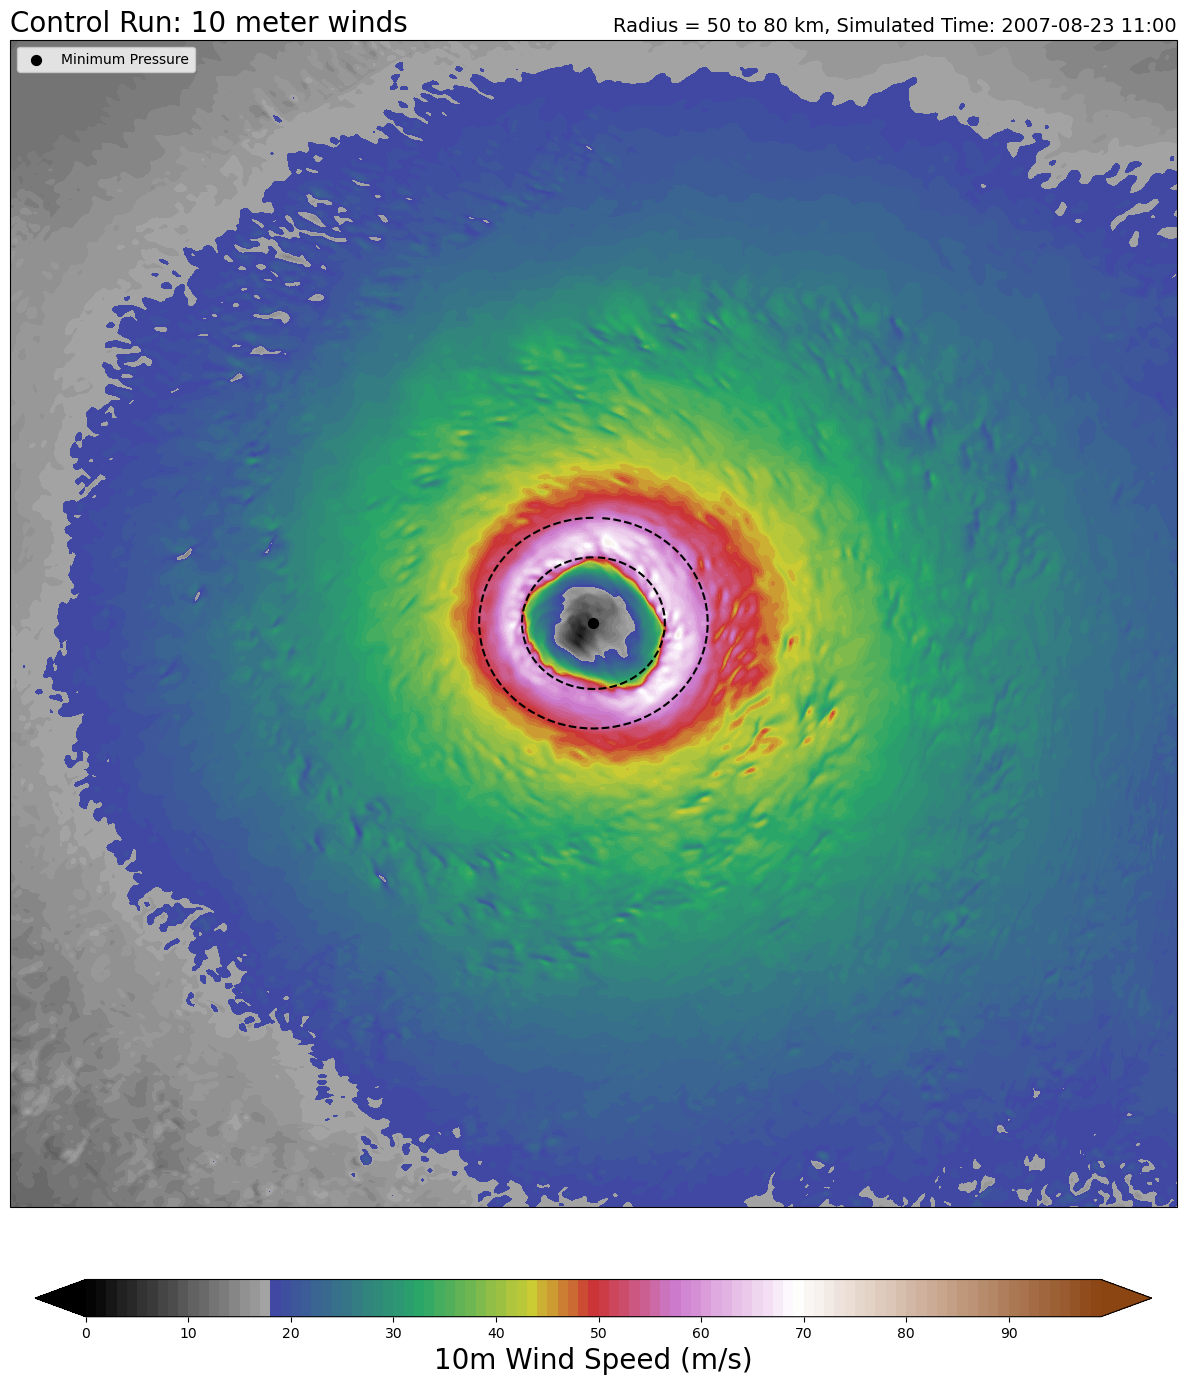

In [12]:
from math import sqrt

#for z in range(1, len(datafiles)):
for z in range(10,11):
    #print(z)
    #print(tc_lon[z].item())

    ncfile = Dataset(datafiles[z])
    wrf_out_data = xr.open_dataset(datafiles[z])   
    Time = wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
    timestr=(str(Time))

    #for plotting
    titletime=(timestr[0:10]+' '+timestr[11:16])
    filetime= (timestr[0:10]+'_'+timestr[11:13])

    #Next, isolate the variable we care to look at, in this case we will only care about the pressure pertubations
    P_pertubation = wrf_out_data['P']
    surface_P_pertubation = P_pertubation[0,0,:,:]
    
    # Apply a Gaussian filter to smooth the pressure field
    smoothed_pressure = gaussian_filter(surface_P_pertubation, sigma=50)  # Adjust sigma as necessary

    # Now find the minimum pressure in the smoothed field
    minpressure_smoothed = np.min(smoothed_pressure)
    print(minpressure_smoothed)
    minp_smoothed = minpressure_smoothed

    # Get the index of the minimum pressure
    p_index_smoothed = np.argwhere(smoothed_pressure == minp_smoothed)
    s_n_smoothed = p_index_smoothed[0][0]
    w_e_smoothed = p_index_smoothed[0][1]

    # Update the storm center position
    ypos = s_n_smoothed
    xpos = w_e_smoothed

    tc_lon = wrf_out_data['XLONG'][0,s_n_smoothed,w_e_smoothed].values
    tc_lat = wrf_out_data['XLAT'][0,s_n_smoothed,w_e_smoothed].values

    fig, ax = create_map_background(tc_lon,tc_lat) #We are only looking at 11 indices, and our list goes from 0-11, not 24 and up

    Terrain_height = wrf_out_data['HGT'][0,:,:].values
    lat = wrf_out_data['XLAT'][0,:,:]
    lon = wrf_out_data['XLONG'][0,:,:]

    nx = lat.shape[0]
    ny = lat.shape[1]

    #calculate olr and all that fun stuff
    wrf_out_OLR =  wrf_out_data['OLR'][0,:,:]
    wrf_out_EMISS = wrf_out_data['EMISS'][0,:,:]
    
    wrf_out_OLR_T = ((wrf_out_OLR.values/(wrf_out_EMISS.values * sigma))**(1/4)) - 273.15

    uvmet10 = getvar(ncfile,"uvmet10")
    u10 = uvmet10[0].values
    v10 = uvmet10[1].values

    wind_10_abs  = np.zeros([nx,ny])
    
    wind_10_abs[:,:] = np.sqrt(u10[:,:]**2 + v10[:,:]**2)

    # plot = plt.contourf(wrf_out_data['XLONG'][0,:,:].values, wrf_out_data['XLAT'][0,:,:].values,  wrf_out_OLR_T,
    #        origin = 'lower', cmap = newcmp, levels = np.arange(-80, 5, 5), alpha = .85, extend ='both')

    plot = plt.contourf(wrf_out_data['XLONG'][0,:,:].values, wrf_out_data['XLAT'][0,:,:].values,  wind_10_abs,
          origins = 'lower', levels = np.arange(0,100,1), cmap = wind_scale(), extend='both')

    cbar = plt.colorbar(plot, orientation = 'horizontal', pad = .05, shrink = .75, aspect = 30, extend = 'both')
    cbar.ax.set_xlabel('10m Wind Speed (m/s)', fontsize = 20)

    plot2 = plt.contour(lon.values, lat.values, Terrain_height, origin = 'lower', levels = np.arange(-1, 2, 1), colors = 'black')

    #for adding a circle to show azimuth 
    
    # Plot the position of the minimum pressure
    p_min_lon = tc_lon
    p_min_lat = tc_lat
    plt.scatter(p_min_lon, p_min_lat, color='black', s=50, zorder=5, label='Minimum Pressure')
    
    # Draw a circle to represent the radius around the minimum pressure point
    radius_km1 = 50                                                         #Specify this radius for what ever radius you want 
    radius_km2 = 80  
    # Define the geodetic circle
    geodetic = Geodesic()
    circle_points1 = geodetic.circle(lon=p_min_lon, lat=p_min_lat, radius=radius_km1 * 1000, n_samples=100)
    circle_points2 = geodetic.circle(lon=p_min_lon, lat=p_min_lat, radius=radius_km2 * 1000, n_samples=100)
    
    # Plot the circle on the map
    ax.plot(circle_points1[:, 0], circle_points1[:, 1], transform=ccrs.Geodetic(), color='black', linestyle='--')
    ax.plot(circle_points2[:, 0], circle_points2[:, 1], transform=ccrs.Geodetic(), color='black', linestyle='--')

    # Update the legend to include the new marker and circle
    plt.legend(loc='upper left')

    plt.title(f'Radius = {radius_km1} to {radius_km2} km, Simulated Time: {titletime}', loc = 'right', fontsize = 14)
    plt.title('Control Run: 10 meter winds', loc = 'left', fontsize = 20)

    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)

    #/glade/work/cmasiello/Control_Run/plots/control_run/d03/annulus_RMW

     #Save Plots to Designated Directory
    plt.savefig("/glade/work/cmasiello/Control_Run/plots/control_run/d03/annulus_RMW/" + titletime)
    
    plt.show()
    plt.close()

In [25]:
#Now that we have a visual what it is doing, let us find the average within that annulus! We will use a mask!!

#for z in range(1, len(datafiles)):
for z in range(10,11):
    ncfile = Dataset(datafiles[z])
    wrf_out_data = xr.open_dataset(datafiles[z])   
    Time = wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
    timestr=(str(Time))

    #for plotting
    titletime=(timestr[0:10]+' '+timestr[11:16])
    filetime= (timestr[0:10]+'_'+timestr[11:13])

    #Next, isolate the variable we care to look at, in this case we will only care about the pressure pertubations
    P_pertubation = wrf_out_data['P']
    surface_P_pertubation = P_pertubation[0,0,:,:]
    
    # Apply a Gaussian filter to smooth the pressure field
    smoothed_pressure = gaussian_filter(surface_P_pertubation, sigma=50)  # Adjust sigma as necessary

    # Now find the minimum pressure in the smoothed field
    minpressure_smoothed = np.min(smoothed_pressure)
    minp_smoothed = minpressure_smoothed

    # Get the index of the minimum pressure
    p_index_smoothed = np.argwhere(smoothed_pressure == minp_smoothed)
    s_n_smoothed = p_index_smoothed[0][0]
    w_e_smoothed = p_index_smoothed[0][1]

    # Update the storm center position
    ypos = s_n_smoothed
    xpos = w_e_smoothed

    tc_lon = wrf_out_data['XLONG'][0,s_n_smoothed,w_e_smoothed].values
    tc_lat = wrf_out_data['XLAT'][0,s_n_smoothed,w_e_smoothed].values

    Terrain_height = wrf_out_data['HGT'][0,:,:].values
    lat = wrf_out_data['XLAT'][0,:,:]
    lon = wrf_out_data['XLONG'][0,:,:]

    nx = lat.shape[0]
    ny = lat.shape[1]

    #calculate olr and all that fun stuff
    wrf_out_OLR =  wrf_out_data['OLR'][0,:,:]
    wrf_out_EMISS = wrf_out_data['EMISS'][0,:,:]
    
    wrf_out_OLR_T = ((wrf_out_OLR.values/(wrf_out_EMISS.values * sigma))**(1/4)) - 273.15

    uvmet10 = getvar(ncfile,"uvmet10")
    u10 = uvmet10[0].values
    v10 = uvmet10[1].values

    wind_10_abs  = np.zeros([nx,ny])
    
    wind_10_abs[:,:] = np.sqrt(u10[:,:]**2 + v10[:,:]**2)

    ######################################################################################################################################
    #cool, we got everything in we are interested in, below, maunally adjust the values of interes!
    inner_radius_km = 50
    outer_radius_km = 80

    ######################################################################################################################################
    #Convert km to meters
    inner_radius_m = inner_radius_km * 1000
    outer_radius_m = outer_radius_km * 1000
    
    ydist, xdist, tcdist, rlonfac   = [np.zeros([nx,ny]) for _ in range(4)]
    u_radial, v_azimuth, windabs    = [np.zeros([nx,ny,n_zlevs]) for _ in range(3)]

    #Calculate the absolute wind speed for all points
    rlonfac[:,:] = 111000.*cos(d2r*lat[:,:])
    ydist[:,:]   = (lat[:,:] - lat[ypos,xpos])*111000
    xdist[:,:]   = (lon[:,:] - (lon[ypos,xpos]))*rlonfac
    tcdist[:,:]  = (xdist[:,:]**2 + ydist[:,:]**2)**0.5

    #Calculate angles in radians from the storm center to each point, and convert to degrees
    y, x = np.indices((nx, ny))
    rel_y = y - ypos
    rel_x = x - xpos
    angles_rad = np.arctan2(rel_y, rel_x)
    angles_deg = np.degrees(angles_rad) % 360

    #Define a mask for the specific radius and tolerance
    radius_mask_annular = (tcdist >= inner_radius_m) & (tcdist <= outer_radius_m)

    #lets goooo, we have created la mask!!!!!
    wind_10_abs_in_mask = [] 
    
    for i in range(nx):
        for j in range(ny):
            if radius_mask_annular[i, j]:
                wind_10_abs_in_mask.append(wind_10_abs[i,j])
                
    # Calculate the mean wind speed
    wind_10_abs_in_annulus_average = np.nanmean(wind_10_abs_in_mask)
    
    print("average 10m winds in the annulus", wind_10_abs_in_annulus_average)

average 10m winds in the annulus 59.48279964385049
